# Imports

In [1]:
import pandas as pd
import bz2
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.gridspec as gridspec
import pickle
import os
from extraction_helpers import *

# Import Data

In [2]:
# If cleaning already done:
# Open processed EM-DAT dataset
#df_emdat = pd.read_csv("data/emdat_processed.csv", index_col = "Dis No")

In [3]:
# If cleaning not done:

data = 'data/emdat.csv'

col_list = \
["Dis No", "Disaster Group", "Disaster Subgroup", 
 "Disaster Type", "Disaster Subtype", "Disaster Subsubtype",
 "Event Name", "Country", "ISO", "Region", "Continent", "Origin", 
 "Start Year", "Start Month", "Start Day", "End Year", "End Month", 
 "End Day", "Total Deaths", "No Injured", "No Affected", "No Homeless", 
 "Total Affected", "Total Damages ('000 US$)", "Dis Mag Value", "Dis Mag Scale"]

df_emdat = pd.read_csv(data, usecols=col_list, index_col="Dis No")

In [4]:
# Rename columns
df_emdat = df_emdat.rename(
    {'Disaster Group': 'Group', 'Disaster Subgroup': 'Subgroup',
     'Disaster Type': 'Type', 'Disaster Subtype': 'Subtype',
     'Disaster Subsubtype': 'Subsubtype', 'Event Name': 'Name',
     'Total Deaths': 'Deaths', 'No Injured': 'Injured', 
     'No Affected': 'Affected', 'No Homeless': 'Homeless',
     'Total Affected': 'TotalAffected', "Total Damages ('000 US$)": 'Damages',
     'Dis Mag Value':'Magnitude', 'Dis Mag Scale': 'Scale'}, 
    axis=1) 

# Clean Data

In [5]:
# Certain major disasters (e.g., Australia fire) don't have end days
# because they last very long. We fill these with the Start Day in 
# order to include them and avoid disasters with a negative duration
df_emdat['End Day'] = df_emdat['End Day'].fillna(df_emdat['Start Day'])

# Map NaN values to 0
df_emdat['Deaths'] = df_emdat['Deaths'].fillna(0)
df_emdat['Injured'] = df_emdat['Injured'].fillna(0)
df_emdat['Affected'] = df_emdat['Affected'].fillna(0)
df_emdat['Homeless'] = df_emdat['Homeless'].fillna(0)
df_emdat['TotalAffected'] = df_emdat['TotalAffected'].fillna(0)
df_emdat['Damages'] = df_emdat['Damages'].fillna(0)
df_emdat['Magnitude'] = df_emdat['Magnitude'].fillna(0)

In [6]:
# Drop any rows with NaN in any of the date components
date_cols = ["Start Year", "Start Month", "Start Day",
             "End Year", "End Month", "End Day"]
df_emdat = df_emdat.dropna(subset=date_cols)

In [7]:
# Sort by date (Year, Month, Day)
df_emdat = df_emdat.sort_values(by=date_cols)

In [8]:
# Remove two entries which have start date == 2021
df_emdat = df_emdat[df_emdat['Start Year'] <= 2020]

In [9]:
# One row which has end date 31.06.2017 which is not possible
# The correct month is July (7) instead of June (6)
df_emdat.loc["2017-0257-IND"]

Group                  Natural
Subgroup          Hydrological
Type                     Flood
Subtype                    NaN
Subsubtype                 NaN
Name                       NaN
Country                  India
ISO                        IND
Region           Southern Asia
Continent                 Asia
Origin           Monsoon rains
Magnitude                  0.0
Scale                      Km2
Start Year                2017
Start Month                6.0
Start Day                  1.0
End Year                  2017
End Month                    6
End Day                   31.0
Deaths                    31.0
Injured                    0.0
Affected                   0.0
Homeless                   0.0
TotalAffected              0.0
Damages                    0.0
Name: 2017-0257-IND, dtype: object

In [10]:
# Modify the df to fix the End Month
df_emdat.at["2017-0257-IND", "End Month"] = 7

In [11]:
# Combine start date components into one StartDate column 
df_emdat_start = df_emdat[["Start Year", "Start Month", "Start Day"]].copy()
df_emdat_start.columns = ["year", "month", "day"]
df_emdat["StartDate"] = pd.to_datetime(df_emdat_start)

In [12]:
# Combine end date components into one EndDate column 
df_emdat_end = df_emdat[["End Year", "End Month", "End Day"]].copy()
df_emdat_end.columns = ["year", "month", "day"]
df_emdat["EndDate"] = pd.to_datetime(df_emdat_end)

In [13]:
# Remove the 6 redundant date component columns
df_emdat.drop(date_cols, axis=1, inplace=True)

In [14]:
# View sample
df_emdat.head(3)

,Group,Subgroup,Type,Subtype,Subsubtype,Name,Country,ISO,Region,Continent,...,Magnitude,Scale,Deaths,Injured,Affected,Homeless,TotalAffected,Damages,StartDate,EndDate
Dis No,,,,,,,,,,,,,,,,,,,,,
2015-0011-MWI,Natural,Hydrological,Flood,Riverine flood,NaN,NaN,Malawi,MWI,Eastern Africa,Africa,...,485939.0,Km2,278.0,645.0,638000.0,0.0,638645.0,390000.0,2015-01-01,2015-01-21
2015-0011-MOZ,Natural,Hydrological,Flood,Riverine flood,NaN,NaN,Mozambique,MOZ,Eastern Africa,Africa,...,0.0,Km2,160.0,0.0,177645.0,0.0,177645.0,0.0,2015-01-01,2015-02-09
2015-0030-MWI,Natural,Meteorological,Storm,Convective storm,Lightning/Thunderstorms,NaN,Malawi,MWI,Eastern Africa,Africa,...,0.0,Kph,5.0,0.0,0.0,350.0,350.0,0.0,2015-01-02,2015-01-04


# Process Data

## Durations

In [15]:
# Create a column storing the duration of each disaster
df_emdat['Duration'] = (df_emdat['EndDate'] - df_emdat['StartDate']).dt.days

array([[<AxesSubplot:title={'center':'Duration'}>]], dtype=object)

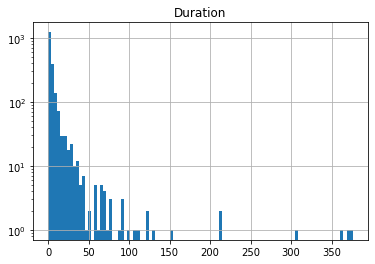

In [16]:
# Plot distribution of durations
df_emdat.hist("Duration", bins=100, log=True)

In [17]:
df_emdat.describe()

,Magnitude,Deaths,Injured,Affected,Homeless,TotalAffected,Damages,Duration
count,1.997000e+03,1997.000000,1997.000000,1.997000e+03,1.997000e+03,1.997000e+03,1.997000e+03,1997.000000
mean,2.063805e+04,36.332999,153.139209,2.498124e+05,2.537447e+03,2.525030e+05,4.542298e+05,6.660491
std,2.023186e+05,255.457778,1936.888509,2.586658e+06,4.850959e+04,2.588110e+06,3.260667e+06,20.843387
min,-4.800000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,0.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,8.800000e+01,0.000000e+00,0.000000
50%,0.000000e+00,6.000000,0.000000,2.000000e+03,0.000000e+00,3.000000e+03,0.000000e+00,2.000000
75%,7.000000e+00,18.000000,4.000000,2.370000e+04,0.000000e+00,2.500000e+04,6.000000e+04,6.000000
max,8.000000e+06,8831.000000,58080.000000,8.500000e+07,2.000000e+06,8.500001e+07,9.500000e+07,376.000000


In [18]:
# Save cleaned EM-DAT dataset
compression_opts = dict(method='zip', archive_name='emdat_processed.csv')  
df_emdat.to_csv('data/emdat_processed.zip', index=True, compression=compression_opts)  

## Chronoligical evolution

In [19]:
# Create dataframe of only disasters between January 2020 and April 2020
mask = ((df_emdat['StartDate'] >= '2020-01-01') & (df_emdat['StartDate'] < '2020-05-01'))
df_2020 = df_emdat.loc[mask]

In [20]:
df_2020.set_index(['StartDate'],inplace=True)

In [21]:
# Some disasters have same StartDate so we group them together and sum the desired column 
grouped_2020 = df_2020.groupby(['StartDate'])

In [22]:
grouped_affected = grouped_2020['TotalAffected'].sum()
grouped_damages = grouped_2020['Damages'].sum()

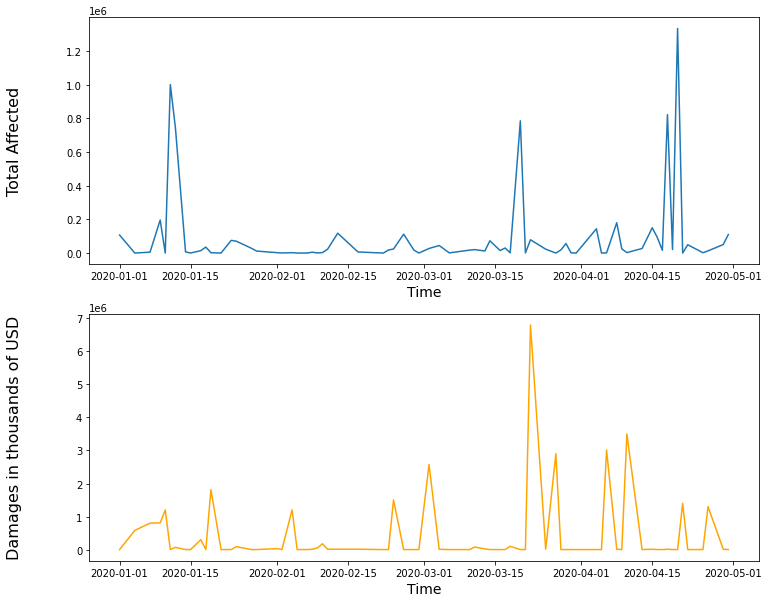

In [23]:
gs = gridspec.GridSpec(2,1)
fig = plt.figure(figsize=(12,10))
#first plot
ax = fig.add_subplot(gs[0])
ax.plot(grouped_affected.index, grouped_affected.values)
ax.set_ylabel(r'Total Affected', size =16)
ax.set_xlabel(r'Time', size =14)
ax.get_yaxis().set_label_coords(-0.1,0.5)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    labelbottom='off') # labels along the bottom edge are off

#second plot
ax = fig.add_subplot(gs[1], sharex=ax)
ax.plot(grouped_damages.index, grouped_damages.values, color='orange')
ax.set_ylabel(r'Damages in thousands of USD', size =16)
ax.set_xlabel(r'Time', size =14)
ax.get_yaxis().set_label_coords(-0.1,0.5)

plt.show()